# 🐕 End-to-end Multi-calss Dog Breed Classification using CNN

## 1. Problem

identifying the breed of dog given an image of a dog.

## 2. Data

the data we're using is from kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

the evaluation is a file with predicted probabilit for each dog breed of each test image.


https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

some information about the data:
* we're dealing with images so it's probably best we use deep learning / transfer learning.
*  there are 120 breeds of dogs.
* there around 10,000+ images in the training set (these images have label).
* there are around 10,000+ images in the test set (these images have no labels).

### Get our workspace ready

* importing TensorFlow 2.x ✅
* importing TensorFlow hub ✅
* make sure we're using GPU ✅

In [5]:
# Importing the TensorFlow into Colab
# importing necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import datetime
import glob
import seaborn as sns
#import IPython
#!pip install -U Ipython
import tf_keras as tfk
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.17.0
Hub version: 0.16.1
GPU not available


In [7]:
# checkout the label of our data
label_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/dog-vision/labels.csv")
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
# checkout the label of our data
label_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/dog-vision/labels.csv")
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
label_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [10]:
label_csv.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [11]:
# let's view an image
image_dir = "drive/MyDrive/Colab Notebooks/dog-vision/train/"
img_path = os.path.join(image_dir, label_csv.id[0] + ".jpg")

In [12]:
# create pathnames from Image ID's
filenames = [image_dir + fname + ".jpg" for fname in label_csv.id.values]

In [13]:
# check whether number of filenames matches number of actual image files
if len(filenames) == len(os.listdir(image_dir)):
  print("Number of filenames matches the number of image files")
else:
  print("Number of filenames does not match the number of image files")

Number of filenames matches the number of image files


In [14]:
labels =label_csv.breed.values
#labels = np.array(labels)
len(labels)

10222

In [15]:
# check if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches the number of filenames")
else:
  print("Number of labels does not match the number of filenames")

Number of labels matches the number of filenames


In [16]:
#make dataframe
data = pd.DataFrame()
data['FilePath'] = filenames
data['Label'] = labels
data.head()

,FilePath,Label
0,drive/MyDrive/Colab Notebooks/dog-vision/train...,boston_bull
1,drive/MyDrive/Colab Notebooks/dog-vision/train...,dingo
2,drive/MyDrive/Colab Notebooks/dog-vision/train...,pekinese
3,drive/MyDrive/Colab Notebooks/dog-vision/train...,bluetick
4,drive/MyDrive/Colab Notebooks/dog-vision/train...,golden_retriever


## Visualizing our Data 📊

In [17]:
def display_images_in_subplots(data, nrows=3, ncols=4, figsize=(10, 7)):
  """
  Displays a grid of images from the provided data in Matplotlib subplots.

  Args:
      data (pandas.DataFrame or similar): A DataFrame-like object containing two columns:
          - 'FilePath': A list of file paths to the images to be displayed.
          - 'Label': A list of labels for each image (optional).
      nrows (int, optional): The number of rows in the subplot grid. Defaults to 3.
      ncols (int, optional): The number of columns in the subplot grid. Defaults to 4.
      figsize (tuple, optional): The width and height of the figure in inches. Defaults to (10, 7).

  Raises:
      ValueError: If the data object does not have 'FilePath' and 'Label' columns (if labels are provided).
      IndexError: If the number of images in 'FilePath' exceeds the available subplots.
  """

  # Check for required columns
  if not all(col in data.columns for col in ['FilePath']):
    raise ValueError("Data must contain a 'FilePath' column.")

  # Check if labels are provided and their length matches image count
  if 'Label' in data.columns and len(data.Label) != len(data.FilePath):
    raise ValueError("'Label' column length must match the number of images.")

  num_images = len(data.FilePath)

  # Ensure nrows and ncols are sufficient
  if num_images > nrows * ncols:
    raise IndexError(f"Not enough subplots to display all images ({num_images}).")

  fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'xticks': [], 'yticks': []})

  axes_flat = axes.flat  # Flatten the axes for iteration

  # Iterate through images and display them
  for i, (filepath, label) in enumerate(zip(data.FilePath, data.get('Label', [''] * num_images))):
    ax = axes_flat[i]
    ax.imshow(plt.imread(filepath))
    if label:
      ax.set_title(label)

  plt.tight_layout()
  plt.show()

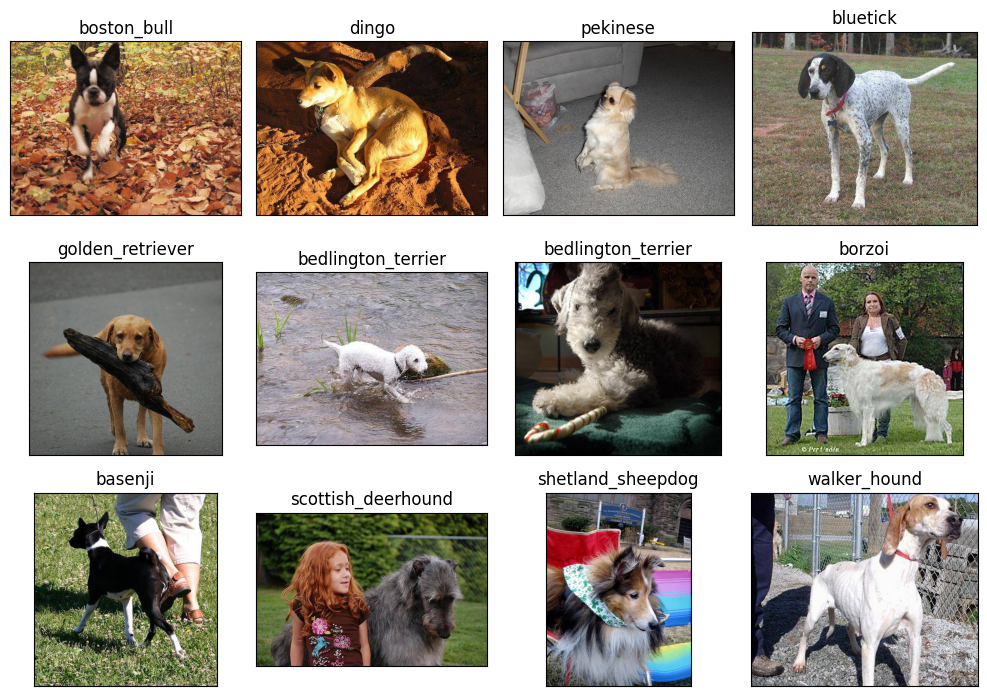

In [22]:
display_images_in_subplots(data=data[:12])

<Axes: xlabel='breed'>

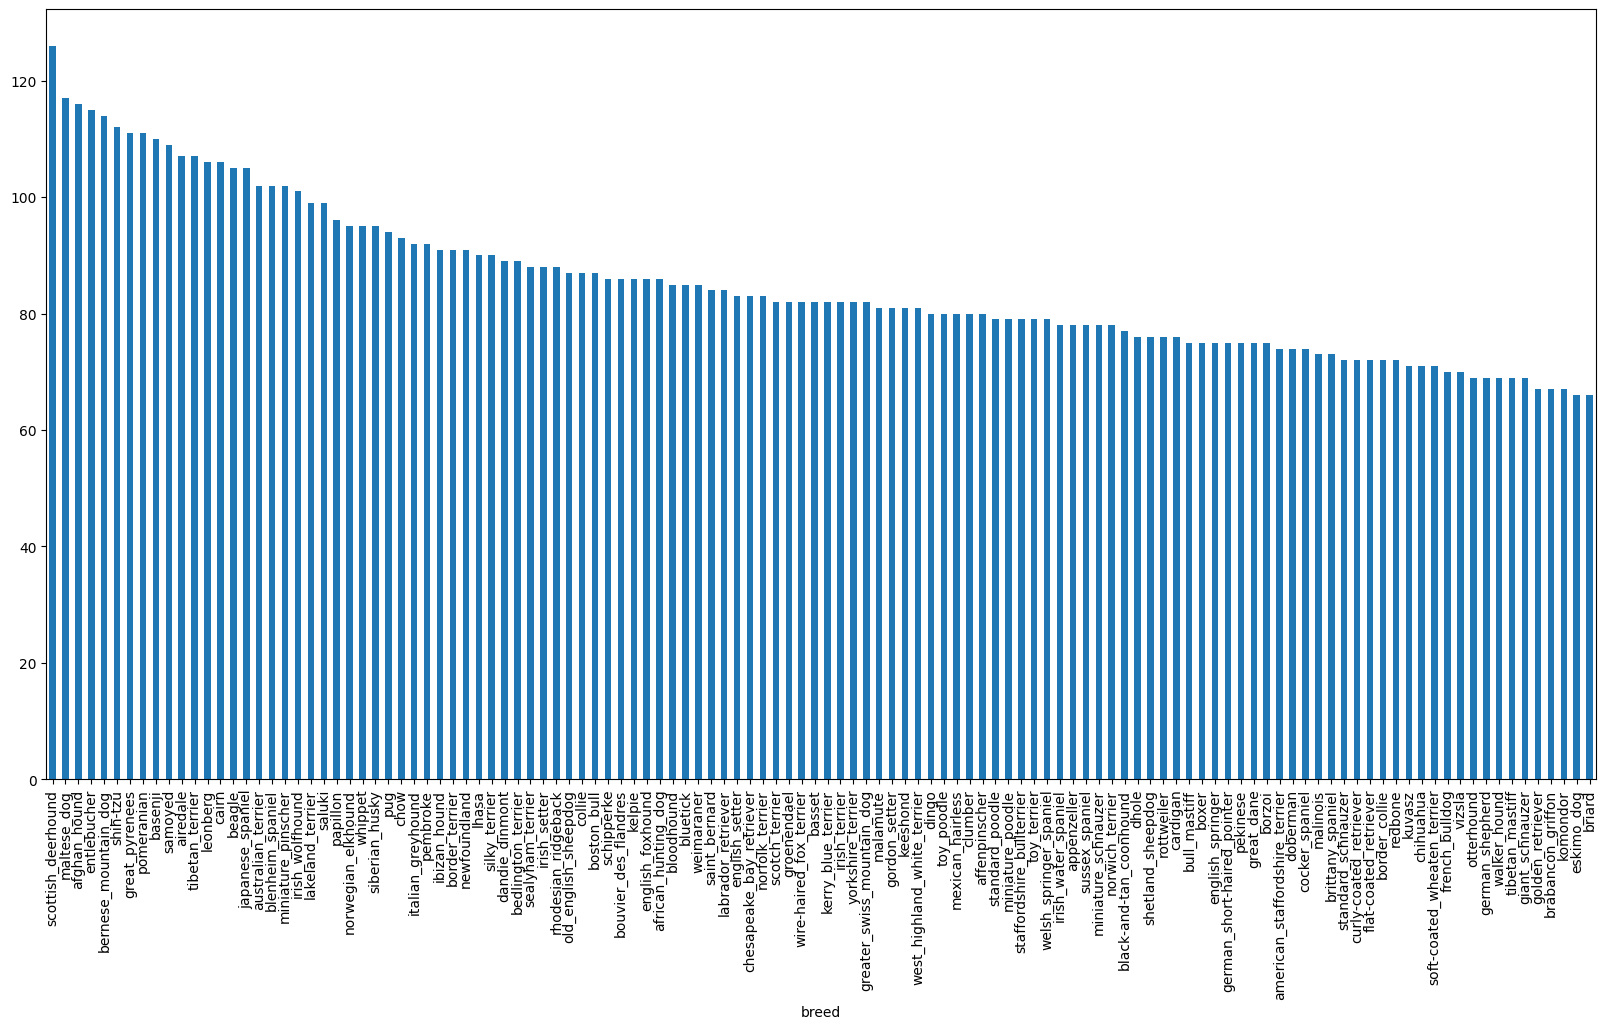

In [75]:
label_csv.breed.value_counts().plot.bar(figsize=(20,10))

## Preprocessing Data

In [18]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds),unique_breeds

(120,
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter'

In [19]:
# turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
# example : turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
# setup X,y variables
X = filenames
y = boolean_labels

In [22]:
# set number of images to use for experimenting
NUM_IMAGES = 10000 # @param {type:"slider", min:1000, max:10000, step:1000}

## Creating our own Training & Validation Sets 📁





In [23]:
# let's split our data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

In [24]:
# Define image size
IMG_SIZE = 32
# make function to preprocessing images
def process_image(image_path,IMG_SIZE=IMG_SIZE):
  """
  this function build for preprocess image like :
    1. Take an image filepath and image size as input
    2. Use TensorFlow to read the file and save it to a variable,`image`
    3. Turn our `image` into tensors
    4. Normalize our image (convert color channel values from 0-255 to 0-1).
    5. Resize the `image` to be a shape (224,224)
    6. Return the modified `image`
  """
  # read in an image file
  image = tf.io.read_file(image_path)
  # turn the jpeg image into numrecal tesor with 3 colour channels (red,green,blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel values from 0-255 to 0-1 value
  image = tf.image.convert_image_dtype(image,tf.float32)
  # resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches

In [25]:
# craete a simble function to return a tuple(image,label)
def get_image_label(image_path,label):
  """
  this function take an image file path name and the assosiated label,
  processes the image and returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image, label

In [26]:
# First of all start with defining a size
BATCH_SIZE = 32

# Our function to turn the data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  This function just created data batches for image, label pairs.
  We do the shuffling if it is the training data, not for validation data.
  We also accpect the test data which do not have any label
  """
  # 1. Test data
  if test_data:
    print("creating test data batches.....")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x)) # Only for filepath as there is no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # 2. Validation data
  elif valid_data:
    print("creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # here both for filepath and label as its validation data
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # 3. Training data
  else:
    print("creating training data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # here both filepath and label as its training data
    # Here we shuffles our data and we do it before mapping inorder to have a faster performance
    data = data.shuffle(buffer_size=len(x))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [27]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

creating training data batches....
creating validation data batches....


In [28]:
# check out the different attributes of our data
train_data.element_spec , val_data.element_spec

((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Modeling

In [29]:
IMG_SIZE = 32

In [30]:
 # setup input shape to the model
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,3]
 # setup the output shape of our model
OUTPUT_SHAPE = 120

### Convolutional Neural Network

In [31]:
def create_cnn_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    """Creates a CNN model for multi-class image classification.

    Args:
        input_shape: The shape of the input images (height, width, channels).
        output_shape: The number of output classes.

    Returns:
        A compiled CNN model.
    """

    cnn = tfk.models.Sequential()

    # Add convolutional layers with batch normalization and pooling
    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tfk.layers.BatchNormalization())
    cnn.add(tfk.layers.MaxPool2D(pool_size=2, strides=2))

    # Flatten the output
    cnn.add(tfk.layers.Flatten())

    # Add dense layers
    cnn.add(tfk.layers.Dense(units=128, activation='relu'))

    # Add output layer
    cnn.add(tfk.layers.Dense(units=output_shape, activation='softmax'))

    cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    my_callbacks  = [tfk.callbacks.EarlyStopping(monitor='val_loss',
                              patience=3,
                              )]


    return cnn,my_callbacks

### Training

In [32]:
# build a function to train and return a trained model
def train_model(model,callback,train_data,val_data):
  """
  Training a given model and returns the trained version.
  """

  # Fit the model to the data passing it the callbacks we created
  histoy=model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            callbacks=callback,
            batch_size=32)
  # Return the model to the data
  return histoy

## Evaluating

In [33]:
def plot_and_evaluate(history, X_test, y_test, model):
  """
  Plots training and validation performance metrics and evaluates the model on test data.

  Args:
      history (History object): Training history object from model.fit().
      X_test (numpy.ndarray): Preprocessed test data (features).
      y_test (numpy.ndarray): Preprocessed test data (labels).
      model (Model): Compiled Keras model.
      test_df (pandas.DataFrame): Test dataframe containing 'FilePath' and 'Label' columns.

  Returns:
      None
  """

  # Plot training and validation accuracy/loss
  fig, ax = plt.subplots(1, 2, figsize=(10, 3))
  ax = ax.ravel()

  for i, met in enumerate(['accuracy', 'loss']):
      ax[i].plot(history.history[met])
      ax[i].plot(history.history['val_' + met])
      ax[i].set_title('Model {}'.format(met))
      ax[i].set_xlabel('Epochs')
      ax[i].set_ylabel(met)
      ax[i].legend(['Train', 'Val'])
  plt.tight_layout()

  # Make predictions on test data
  predictions = model.predict(X_test)
  predicted_classes = np.argmax(predictions, axis=1)  # Get class indices

  # Convert class indices to labels (assuming you have a separate mapping)
  class_labels = {index: label for index, label in enumerate(unique_breeds)}  # Replace with your mapping
  predicted_labels = [class_labels[k] for k in predicted_classes]

  # Print classification report
  print("Classification Report:")
  print(classification_report(y_test, predicted_labels))

  # Create confusion matrix
  confusion_matrix_ = confusion_matrix(y_test, predicted_labels)
  print("\nConfusion Matrix:")
  print(confusion_matrix_)

  # Display 6 pictures with their true and predicted labels
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})

  for i, ax in enumerate(axes.flat):
      image = X_test[i + 1]  # Assuming the first element is for validation (adjust indexing)
      ax.imshow(image)
      ax.set_title(f"True: {y_test[i + 1]}\nPredicted: {predicted_labels[i + 1]}")
  plt.tight_layout()
  plt.show()

In [34]:
def result_test(test, model_use):
  """
  Evaluates a model on a test dataset.

  Args:
    test: A test data generator.
    model_use: The compiled Keras model.

  Returns:
    A tuple containing the test loss and accuracy.
  """

  results = model_use.evaluate(test, verbose=0)

  print("    Test Loss: {:.5f}".format(results[0]))
  print("Test Accuracy: {:.2f}%".format(results[1] * 100))

  return results

## Saving a model

In [35]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("/content/drive/MyDrive/Colab Notebooks/dog-vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

## Create CNN Model and Fit it

## build the CNN model

In [36]:
model_cnn,callback_cnn = create_cnn_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 32)        128       
 chNormalization)                                                
                                                        

In [37]:
NUM_EPOCHS = 50 #@param {type:"slider", min:10, max:100, step:10}


In [38]:
%%time
history_cnn = train_model(model_cnn,callback_cnn,train_data,val_data)

Epoch 1/50
256/256 [==============================] - 446s 2s/step - loss: 4.7168 - accuracy: 0.0230 - val_loss: 5.4336 - val_accuracy: 0.0088
Epoch 2/50
256/256 [==============================] - 77s 299ms/step - loss: 4.3297 - accuracy: 0.0556 - val_loss: 4.5531 - val_accuracy: 0.0445
Epoch 3/50
256/256 [==============================] - 79s 308ms/step - loss: 4.1130 - accuracy: 0.0790 - val_loss: 4.5644 - val_accuracy: 0.0430
Epoch 4/50
256/256 [==============================] - 74s 290ms/step - loss: 3.9297 - accuracy: 0.1065 - val_loss: 4.3750 - val_accuracy: 0.0597
Epoch 5/50
256/256 [==============================] - 69s 269ms/step - loss: 3.7631 - accuracy: 0.1298 - val_loss: 4.3832 - val_accuracy: 0.0641
Epoch 6/50
256/256 [==============================] - 75s 294ms/step - loss: 3.5794 - accuracy: 0.1584 - val_loss: 4.4553 - val_accuracy: 0.0553
Epoch 7/50
256/256 [==============================] - 86s 337ms/step - loss: 3.3980 - accuracy: 0.1927 - val_loss: 4.4948 - val_accu

In [40]:
# Save our model trained on images
save_model(model_cnn, suffix="images-classification-cnn-Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/dog-vision/models/20241016-21271729114064-images-classification-cnn-Adam.h5...


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Colab Notebooks/dog-vision/models/20241016-21271729114064-images-classification-cnn-Adam.h5'

In [43]:
result_test(val_data,model_cnn)

    Test Loss: 4.49484
Test Accuracy: 6.36%


[4.494844436645508, 0.06356967985630035]